In [442]:
import pandas as pd
import numpy as np
import sys
import os
import comtypes.client
import matplotlib.pyplot as plt

# <center>**Find and Attach to ETABS Instance**<center>

In [443]:
# Note: can only attach to one active ETABS model. Please close all other models.
helper = None

# Create API helper object.
helper = comtypes.client.CreateObject('ETABSv1.Helper')
helper = helper.QueryInterface(comtypes.gen.ETABSv1.cHelper)  # type: ignore

try:
    # Get the current ETABS instance.
    myETABSObject = helper.GetObject("CSI.ETABS.API.ETABSObject")
except (OSError, comtypes.COMError):
    print("No running instance of the program found or failed to attach.")
    sys.exit(-1)

# Create SapModel object (ETABS instance)
try:
    SapModel = myETABSObject.SapModel
    print("Successfully connected to ETABS instance.")
except AttributeError:
    print("No running instance of the program found or failed to attach.")

SapModel = None  # Resetting to None before reinitializing
SapModel = myETABSObject.SapModel

Successfully connected to ETABS instance.


# <center>**Extraction of Story Height and Elevations**<center>

In [444]:
# Grab the story definitions table.
story_definition_table = SapModel.DatabaseTables.GetTableForDisplayArray("Story Definitions", GroupName = "") # type: ignore

# Extract the column headings and number of rows from the table. This needs to be done as the data is currently an array.
cols = story_definition_table[2]
num_rows = story_definition_table[3]

# Input data into array split.
table_data = np.array_split(story_definition_table[4], num_rows)

# Create story definitions dataframe.
storyDefinitions_df = pd.DataFrame(table_data)
storyDefinitions_df.columns = cols

# Delete all columns except story and height.
storyDefinitions_df = storyDefinitions_df.drop(['Tower', 'IsMaster', 'SimilarTo', 'IsSpliced', 'SpliceHt', 'Color', 'GUID'], axis=1)

# Rename height column to Story Height (m)
storyDefinitions_df = storyDefinitions_df.rename(columns={'Height': 'Story Height (m)'})

# Convert all data in story height column to metre from millimeter.
storyDefinitions_df['Story Height (m)'] = storyDefinitions_df['Story Height (m)'].astype(int)
storyDefinitions_df['Story Height (m)'] = storyDefinitions_df['Story Height (m)'] / 1000

# Insert Elevation (m) column.
storyDefinitions_df.insert(loc = 1, column= 'Elevation (m)', value = 0)

# Subtract the groundfloor story height by the basement height and add it to GF elevation. The basement height value must be altered manually.
storyDefinitions_df.at[storyDefinitions_df.index[-1], 'Elevation (m)'] = storyDefinitions_df.at[storyDefinitions_df.index[-1], 'Story Height (m)'] - 0.7 # CHANGE THIS VALUE 

# Loop through the dataframe and sum the story heights to get the total building elevation
for i in reversed(range(1, len(storyDefinitions_df))):
    storyDefinitions_df.loc[i - 1, 'Elevation (m)'] = storyDefinitions_df.loc[i, 'Elevation (m)'] + storyDefinitions_df.loc[i - 1, 'Story Height (m)'] # type: ignore

# <center>**Overall Wind Displacement in X & Y Direction - Calculation and Extraction**<center>

In [445]:
# Please manually select the load combination you wish to assess. It will automatically be loaded in.

# Grab the diaphragm center of mass displacements table.
mass_displacement_table = SapModel.DatabaseTables.GetTableForDisplayArray("Diaphragm Center Of Mass Displacements", GroupName = "") # type: ignore

# Extract the column headings and number of rows from the table. This needs to be done as the data is currently an array.
cols = mass_displacement_table[2]
num_rows = mass_displacement_table[3]

# Input data into array split.
table_data = np.array_split(mass_displacement_table[4], num_rows)

# Create wind displacement dataframe.
windDisplacement_df = pd.DataFrame(table_data)
windDisplacement_df.columns = cols

# Loop through the wind displacement dataframe and drop all rows containing non D1 diaphragms.
windDisplacement_df = windDisplacement_df[windDisplacement_df['Diaphragm'] == 'D1']

# Loop through the wind displacement dataframe and drop all rows containing min. This will be the max dataframe.
max_windDisplacement_df = windDisplacement_df[windDisplacement_df['StepType'] == 'Max']

# Loop through the wind displacement dataframe and drop all rows containing Max. This will be the min dataframe.
min_windDisplacement_df = windDisplacement_df[windDisplacement_df['StepType'] == 'Min']

# Reset indices to ensure that the rows are indexed correctly.
max_windDisplacement_df.reset_index(drop=True, inplace=True)
min_windDisplacement_df.reset_index(drop=True, inplace=True)

# Create new dataframes for min and max overall wind displacement to populate relevant data
overall_min_windDisplacement_df = pd.DataFrame(columns=['Story', 'Elevation (m)', 'Story Height (m)', 'Allowable Limit', 'X Direction Displacement (mm) - 80% Codal Wind Load', 'Y Direction Displacement (mm) - 80% Codal Wind Load'])
overall_max_windDisplacement_df = pd.DataFrame(columns=['Story', 'Elevation (m)', 'Story Height (m)', 'Allowable Limit', 'X Direction Displacement (mm) - 80% Codal Wind Load', 'Y Direction Displacement (mm) - 80% Codal Wind Load'])

# Populate columns of new dataframes with appropriate data.
overall_min_windDisplacement_df['Story'] = storyDefinitions_df['Story']
overall_max_windDisplacement_df['Story'] = storyDefinitions_df['Story']
overall_min_windDisplacement_df['Elevation (m)'] = storyDefinitions_df['Elevation (m)']
overall_max_windDisplacement_df['Elevation (m)'] = storyDefinitions_df['Elevation (m)']
overall_min_windDisplacement_df['Story Height (m)'] = storyDefinitions_df['Story Height (m)']
overall_max_windDisplacement_df['Story Height (m)'] = storyDefinitions_df['Story Height (m)']
overall_min_windDisplacement_df['Allowable Limit'] = round(storyDefinitions_df['Elevation (m)'] * 1000 / 500)
overall_max_windDisplacement_df['Allowable Limit'] = round(storyDefinitions_df['Elevation (m)'] * 1000 / 500)
overall_min_windDisplacement_df['X Direction Displacement (mm) - 80% Codal Wind Load'] = min_windDisplacement_df['UX']
overall_max_windDisplacement_df['X Direction Displacement (mm) - 80% Codal Wind Load'] = max_windDisplacement_df['UX']
overall_min_windDisplacement_df['Y Direction Displacement (mm) - 80% Codal Wind Load'] = min_windDisplacement_df['UY']
overall_max_windDisplacement_df['Y Direction Displacement (mm) - 80% Codal Wind Load'] = max_windDisplacement_df['UY']

# Convert column datatypes to float to enable plotting.
overall_max_windDisplacement_df['X Direction Displacement (mm) - 80% Codal Wind Load'] = overall_max_windDisplacement_df['X Direction Displacement (mm) - 80% Codal Wind Load'].astype(float)
overall_max_windDisplacement_df['Y Direction Displacement (mm) - 80% Codal Wind Load'] = overall_max_windDisplacement_df['Y Direction Displacement (mm) - 80% Codal Wind Load'].astype(float)
overall_min_windDisplacement_df['X Direction Displacement (mm) - 80% Codal Wind Load'] = overall_min_windDisplacement_df['X Direction Displacement (mm) - 80% Codal Wind Load'].astype(float)
overall_min_windDisplacement_df['Y Direction Displacement (mm) - 80% Codal Wind Load'] = overall_min_windDisplacement_df['Y Direction Displacement (mm) - 80% Codal Wind Load'].astype(float)


# Take minimum values and make absolute to enable plotting.
overall_min_windDisplacement_df['X Direction Displacement (mm) - 80% Codal Wind Load'] = overall_min_windDisplacement_df['X Direction Displacement (mm) - 80% Codal Wind Load'].abs()
overall_min_windDisplacement_df['Y Direction Displacement (mm) - 80% Codal Wind Load'] = overall_min_windDisplacement_df['Y Direction Displacement (mm) - 80% Codal Wind Load'].abs()

# <center>**Overall Wind Displacement in X & Y Direction - Plotting Maximum**<center>

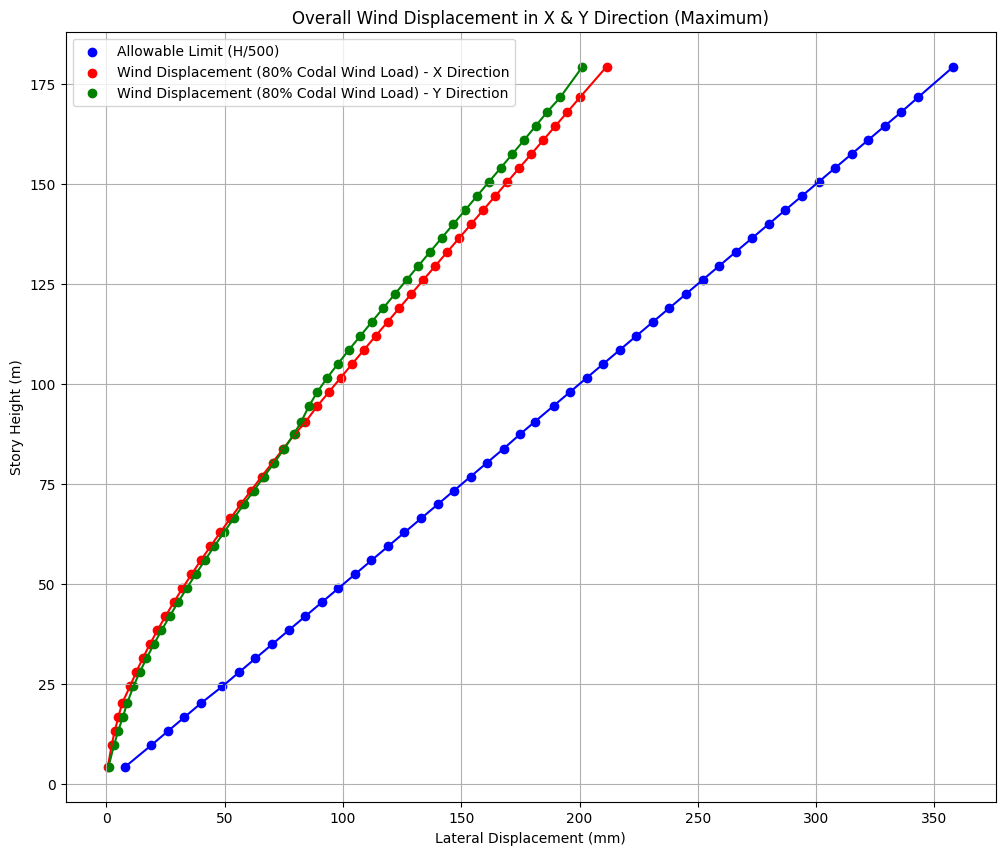

In [470]:
#Set the figure size
plt.figure(figsize=(12,10)) 

# Create scatterplot of allowable limit.
plt.scatter(overall_max_windDisplacement_df['Allowable Limit'], overall_max_windDisplacement_df['Elevation (m)'], label='Allowable Limit (H/500)', color='b')

# Create scatterplot of maximum wind displacement in x direction.
plt.scatter(overall_max_windDisplacement_df['X Direction Displacement (mm) - 80% Codal Wind Load'], overall_max_windDisplacement_df['Elevation (m)'], label='Wind Displacement (80% Codal Wind Load) - X Direction', color='r')

# Create scatterplot of maximum wind displacement in y direction.
plt.scatter(overall_max_windDisplacement_df['Y Direction Displacement (mm) - 80% Codal Wind Load'], overall_max_windDisplacement_df['Elevation (m)'], label='Wind Displacement (80% Codal Wind Load) - Y Direction', color='g')

# Plot the points with a solid connecting line
plt.plot(overall_max_windDisplacement_df['Allowable Limit'], overall_max_windDisplacement_df['Elevation (m)'], "b-")
plt.plot(overall_max_windDisplacement_df['X Direction Displacement (mm) - 80% Codal Wind Load'], overall_max_windDisplacement_df['Elevation (m)'], "r-")
plt.plot(overall_max_windDisplacement_df['Y Direction Displacement (mm) - 80% Codal Wind Load'], overall_max_windDisplacement_df['Elevation (m)'], "g-")

# Add label, title, legend, and show the plot.
plt.xlabel('Lateral Displacement (mm)')
plt.ylabel('Story Height (m)')
plt.title('Overall Wind Displacement in X & Y Direction (Maximum)')
plt.legend()
plt.grid(True)
plt.show()

# <center>**Overall Wind Displacement in X & Y Direction - Plotting Minimum**<center>

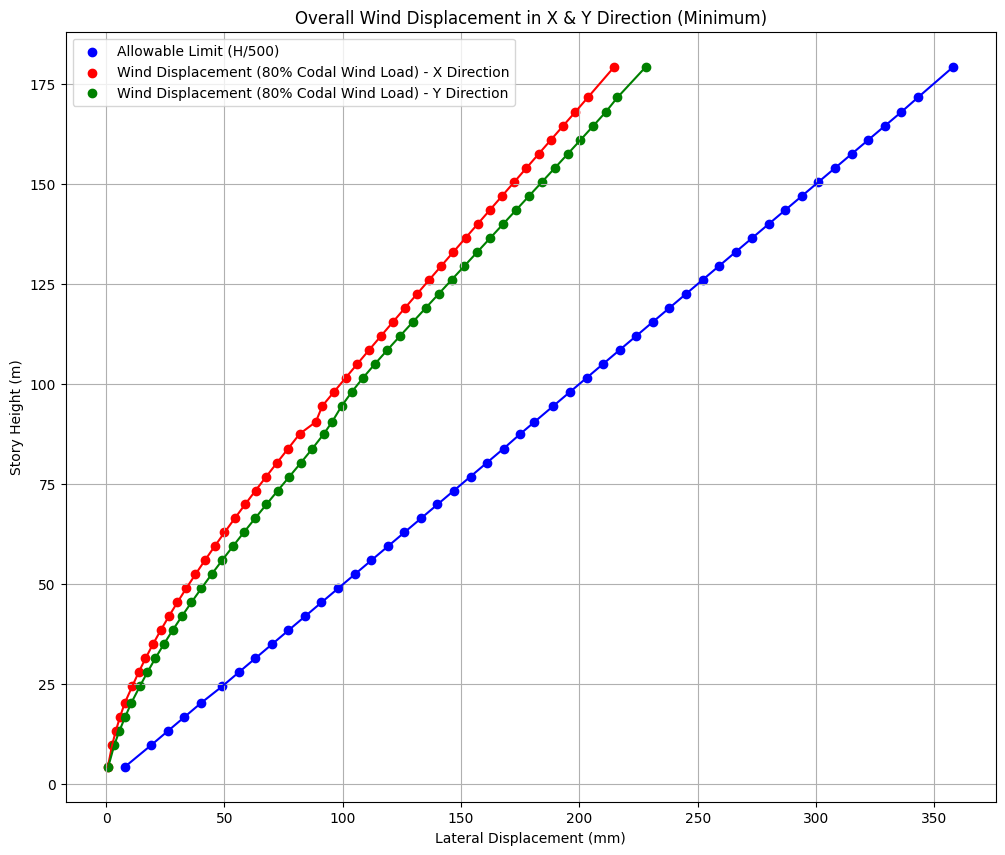

In [447]:
#Set the figure size
plt.figure(figsize=(12,10)) 

# Create scatterplot of allowable limit.
plt.scatter(overall_min_windDisplacement_df['Allowable Limit'], overall_min_windDisplacement_df['Elevation (m)'], label='Allowable Limit (H/500)', color='b')

# Create scatterplot of maximum wind displacement in x direction.
plt.scatter(overall_min_windDisplacement_df['X Direction Displacement (mm) - 80% Codal Wind Load'], overall_min_windDisplacement_df['Elevation (m)'], label='Wind Displacement (80% Codal Wind Load) - X Direction', color='r')

# Create scatterplot of maximum wind displacement in y direction.
plt.scatter(overall_min_windDisplacement_df['Y Direction Displacement (mm) - 80% Codal Wind Load'], overall_min_windDisplacement_df['Elevation (m)'], label='Wind Displacement (80% Codal Wind Load) - Y Direction', color='g')

# Plot the points with a solid connecting line
plt.plot(overall_min_windDisplacement_df['Allowable Limit'], overall_min_windDisplacement_df['Elevation (m)'], "b-")
plt.plot(overall_min_windDisplacement_df['X Direction Displacement (mm) - 80% Codal Wind Load'], overall_min_windDisplacement_df['Elevation (m)'], "r-")
plt.plot(overall_min_windDisplacement_df['Y Direction Displacement (mm) - 80% Codal Wind Load'], overall_min_windDisplacement_df['Elevation (m)'], "g-")

# Add label, title, legend, and show the plot.
plt.xlabel('Lateral Displacement (mm)')
plt.ylabel('Story Height (m)')
plt.title('Overall Wind Displacement in X & Y Direction (Minimum)')
plt.legend()
plt.grid(True)
plt.show()

# <center>**Wind Interstory Drift - Calculation and Extraction**<center>

In [457]:
# Please manually select the load combination you wish to assess. It will automatically be loaded in.

# Grab the diaphragm center of mass displacements table.
storyDrift_table = SapModel.DatabaseTables.GetTableForDisplayArray("Story Drifts", GroupName = "") # type: ignore

# Extract the column headings and number of rows from the table. This needs to be done as the data is currently an array.
cols = storyDrift_table[2]
num_rows = storyDrift_table[3]

# Input data into array split.
table_data = np.array_split(storyDrift_table[4], num_rows)

# Create Story Drifts dataframe.
storyDrifts_df = pd.DataFrame(table_data)
storyDrifts_df.columns = cols

In [458]:
# Create a copy of Story Drifts dataframe for seismic manipulation
seismic_storyDrifts_df = storyDrifts_df.copy()

# Loop through story drifts dataframe and filter out min values.
storyDrifts_df = storyDrifts_df[storyDrifts_df['StepType'] == 'Max']

# Separate X and Y direction values into different dataframes.
x_storyDrifts_df = storyDrifts_df[storyDrifts_df['Direction'] == 'X']
y_storyDrifts_df = storyDrifts_df[storyDrifts_df['Direction'] == 'Y']

# Reset the indices to ensure that the rows are indexed correctly.
x_storyDrifts_df.reset_index(drop=True, inplace=True)
y_storyDrifts_df.reset_index(drop=True, inplace=True)

#Create new dataframe to populate relevant data.
overall_storyDrifts_df = pd.DataFrame(columns=['Story', 'Elevation (m)', 'Story Height (m)', 'Allowable Limit (H/500)', 'Story Drift - Codal Wind Load - X Direction', 'Story Drift - Codal Wind Load - Y Direction'])

# Populate columns of new dataframes with appropriate data.
overall_storyDrifts_df['Story'] = storyDefinitions_df['Story']
overall_storyDrifts_df['Elevation (m)'] = storyDefinitions_df['Elevation (m)']
overall_storyDrifts_df['Story Height (m)'] = storyDefinitions_df['Story Height (m)']
overall_storyDrifts_df['Allowable Limit (H/500)'] = 0.002
overall_storyDrifts_df['Story Drift - Codal Wind Load - X Direction'] = x_storyDrifts_df['Drift']
overall_storyDrifts_df['Story Drift - Codal Wind Load - Y Direction'] = y_storyDrifts_df['Drift']

# Convert column datatypes to float to enable plotting.
overall_storyDrifts_df['Story Drift - Codal Wind Load - X Direction'] = overall_storyDrifts_df['Story Drift - Codal Wind Load - X Direction'].astype(float)
overall_storyDrifts_df['Story Drift - Codal Wind Load - Y Direction'] = overall_storyDrifts_df['Story Drift - Codal Wind Load - Y Direction'].astype(float)

# <center>**Wind Interstory Drift - Plotting**<center>

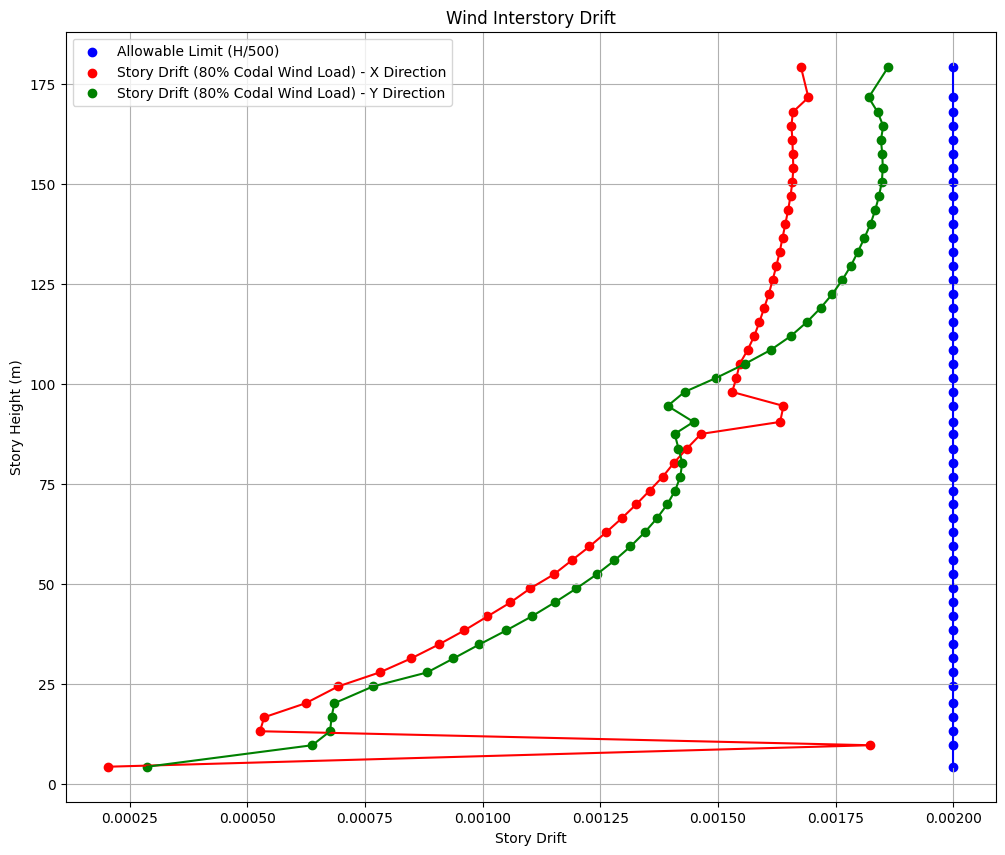

In [459]:
#Set the figure size.
plt.figure(figsize=(12,10)) 

# Create scatterplot of allowable limit.
plt.scatter(overall_storyDrifts_df['Allowable Limit (H/500)'], overall_storyDrifts_df['Elevation (m)'], label='Allowable Limit (H/500)', color='b')

# Create scatterplot of wind interstory drift in x direction.
plt.scatter(overall_storyDrifts_df['Story Drift - Codal Wind Load - X Direction'], overall_storyDrifts_df['Elevation (m)'], label='Story Drift (80% Codal Wind Load) - X Direction', color='r')

# Create scatterplot of wind interstory drift in y direction.
plt.scatter(overall_storyDrifts_df['Story Drift - Codal Wind Load - Y Direction'], overall_storyDrifts_df['Elevation (m)'], label='Story Drift (80% Codal Wind Load) - Y Direction', color='g')


#Plot the points with a solid connecting line
plt.plot(overall_storyDrifts_df['Allowable Limit (H/500)'], overall_storyDrifts_df['Elevation (m)'], "b-")
plt.plot(overall_storyDrifts_df['Story Drift - Codal Wind Load - X Direction'], overall_storyDrifts_df['Elevation (m)'], "r-")
plt.plot(overall_storyDrifts_df['Story Drift - Codal Wind Load - Y Direction'], overall_storyDrifts_df['Elevation (m)'], "g-")


# Add label, title, legend, and show the plot.
plt.xlabel('Story Drift')
plt.ylabel('Story Height (m)')
plt.title('Wind Interstory Drift')
plt.legend()
plt.grid(True)
plt.show()

# <center>**Seismic Interstory Drift - Calculation and Extraction**<center>

In [471]:
# Separate story drifts dataframe into minimum and maximum.
min_storyDrifts_df = seismic_storyDrifts_df[seismic_storyDrifts_df['StepType'] == 'Min']
max_storyDrifts_df = seismic_storyDrifts_df[seismic_storyDrifts_df['StepType'] == 'Max']

# Separate story drifts dataframe into x and y direction for both min and max.
x_min_storyDrifts_df = min_storyDrifts_df[min_storyDrifts_df['Direction'] == 'X']
y_min_storyDrifts_df = min_storyDrifts_df[min_storyDrifts_df['Direction'] == 'Y']
x_max_storyDrifts_df = max_storyDrifts_df[max_storyDrifts_df['Direction'] == 'X']
y_max_storyDrifts_df = max_storyDrifts_df[max_storyDrifts_df['Direction'] == 'Y']

# Reset the indices to ensure that the rows are indexed correctly.
x_min_storyDrifts_df.reset_index(drop=True, inplace=True)
y_min_storyDrifts_df.reset_index(drop=True, inplace=True)
x_max_storyDrifts_df.reset_index(drop=True, inplace=True)
y_max_storyDrifts_df.reset_index(drop=True, inplace=True)

# Convert column datatyes to float to enable calculation and plotting.
x_min_storyDrifts_df.loc[:, 'Drift'] = x_min_storyDrifts_df['Drift'].astype(float)
y_min_storyDrifts_df.loc[:, 'Drift'] = y_min_storyDrifts_df['Drift'].astype(float)
x_max_storyDrifts_df.loc[:, 'Drift'] = x_max_storyDrifts_df['Drift'].astype(float)
y_max_storyDrifts_df.loc[:, 'Drift'] = y_max_storyDrifts_df['Drift'].astype(float)


# Create new dataframes to populate relevant data.
min_seismic_storyDrifts_df = pd.DataFrame(columns=['Story', 'Elevation (m)', 'Story Height (m)', 'Allowable Limit (H/500)', 'Elastic Seismic Story Drift - X Direction', 'Elastic Seismic Story Drift - Y Direction', 'Inelastic Seismic Story Drift - X Direction', 'Inelastic Seismic Story Drift - Y Direction'])
max_seismic_storyDrifts_df = pd.DataFrame(columns=['Story', 'Elevation (m)', 'Story Height (m)', 'Allowable Limit (H/500)', 'Elastic Seismic Story Drift - X Direction', 'Elastic Seismic Story Drift - Y Direction', 'Inelastic Seismic Story Drift - X Direction', 'Inelastic Seismic Story Drift - Y Direction'])

# CHANGE THESE VARIABLES BASED ON SEISMIC INFORMATION:
deflectionAmplification_cd = 4
occupancyImportance_I = 1
inelasticResponse = deflectionAmplification_cd / occupancyImportance_I

# Populate columns of new dataframes with appropriate data.
min_seismic_storyDrifts_df['Story'] = storyDefinitions_df['Story']
min_seismic_storyDrifts_df['Elevation (m)'] = storyDefinitions_df['Elevation (m)']
min_seismic_storyDrifts_df['Story Height (m)'] = storyDefinitions_df['Story Height (m)']
min_seismic_storyDrifts_df['Allowable Limit (H/500)'] = 0.02
min_seismic_storyDrifts_df['Elastic Seismic Story Drift - X Direction'] = x_min_storyDrifts_df['Drift']
min_seismic_storyDrifts_df['Elastic Seismic Story Drift - Y Direction'] = y_min_storyDrifts_df['Drift']
min_seismic_storyDrifts_df['Inelastic Seismic Story Drift - X Direction'] = x_min_storyDrifts_df['Drift'] * inelasticResponse
min_seismic_storyDrifts_df['Inelastic Seismic Story Drift - Y Direction'] = y_min_storyDrifts_df['Drift'] * inelasticResponse

max_seismic_storyDrifts_df['Story'] = storyDefinitions_df['Story']
max_seismic_storyDrifts_df['Elevation (m)'] = storyDefinitions_df['Elevation (m)']
max_seismic_storyDrifts_df['Story Height (m)'] = storyDefinitions_df['Story Height (m)']
max_seismic_storyDrifts_df['Allowable Limit (H/500)'] = 0.02
max_seismic_storyDrifts_df['Elastic Seismic Story Drift - X Direction'] = x_max_storyDrifts_df['Drift']
max_seismic_storyDrifts_df['Elastic Seismic Story Drift - Y Direction'] = y_max_storyDrifts_df['Drift']
max_seismic_storyDrifts_df['Inelastic Seismic Story Drift - X Direction'] = x_max_storyDrifts_df['Drift'] * inelasticResponse
max_seismic_storyDrifts_df['Inelastic Seismic Story Drift - Y Direction'] = y_max_storyDrifts_df['Drift'] * inelasticResponse

min_seismic_storyDrifts_df.tail(10)

,Story,Elevation (m),Story Height (m),Allowable Limit (H/500),Elastic Seismic Story Drift - X Direction,Elastic Seismic Story Drift - Y Direction,Inelastic Seismic Story Drift - X Direction,Inelastic Seismic Story Drift - Y Direction
39,L9,38.275,3.500,0.02,0.001015,0.001184,0.00406,0.004736
40,L8,34.775,3.500,0.02,0.00096,0.001123,0.00384,0.004492
41,L7,31.275,3.500,0.02,0.000902,0.001058,0.003608,0.004232
42,L6,27.775,3.500,0.02,0.000844,0.000993,0.003376,0.003972
43,L5,24.275,4.200,0.02,0.000769,0.000943,0.003076,0.003772
44,P4,20.075,3.500,0.02,0.000696,0.000841,0.002784,0.003364
45,P3,16.575,3.500,0.02,0.000721,0.000814,0.002884,0.003256
46,P2,13.075,3.500,0.02,0.000625,0.000706,0.0025,0.002824
47,P1,9.575,5.375,0.02,0.003182,0.000644,0.012728,0.002576
48,GF,4.200,4.900,0.02,0.000231,0.000396,0.000924,0.001584


# <center>**Maximum Seismic Interstory Drift - Plotting**<center>

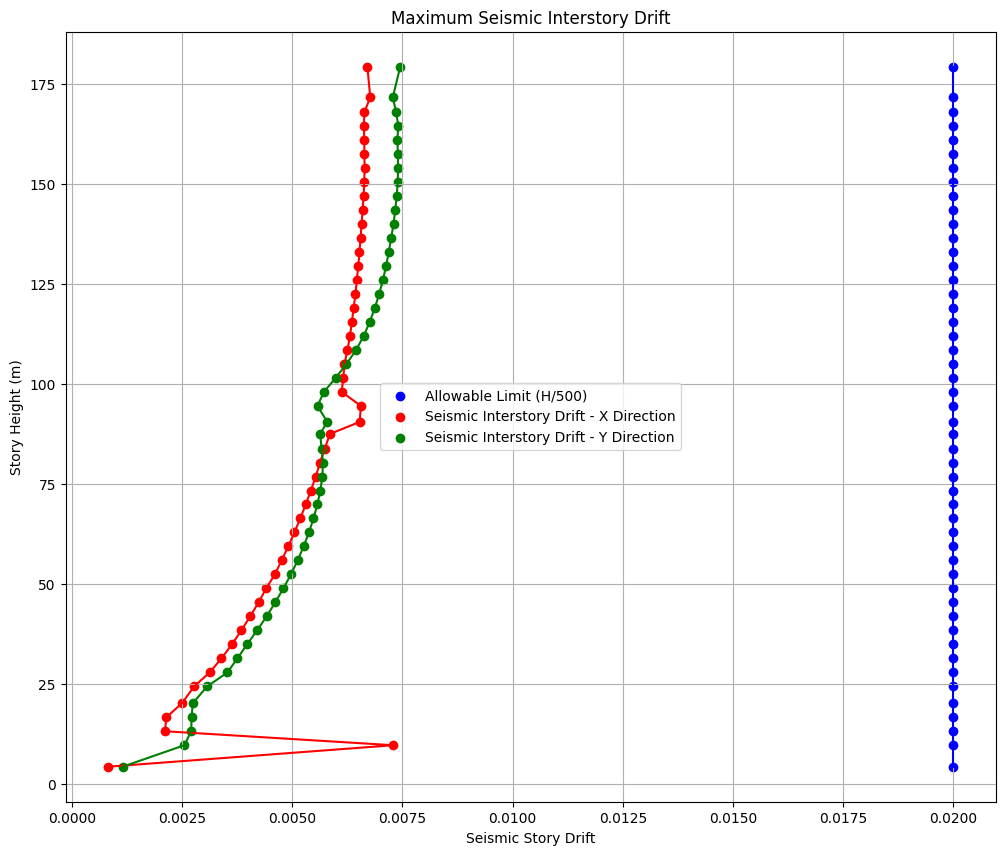

In [464]:
#Set the figure size.
plt.figure(figsize=(12,10))

# Create scatterplot of allowable limit.
plt.scatter(max_seismic_storyDrifts_df['Allowable Limit (H/500)'], max_seismic_storyDrifts_df['Elevation (m)'], label='Allowable Limit (H/500)', color='b')

# Create scatterplot of max seismic interstory drift in x direction.
plt.scatter(max_seismic_storyDrifts_df['Inelastic Seismic Story Drift - X Direction'], max_seismic_storyDrifts_df['Elevation (m)'], label='Seismic Interstory Drift - X Direction', color='r')

# Create scatterplot of max seismic interstory drift in y direction.
plt.scatter(max_seismic_storyDrifts_df['Inelastic Seismic Story Drift - Y Direction'], max_seismic_storyDrifts_df['Elevation (m)'], label='Seismic Interstory Drift - Y Direction', color='g')

#Plot the points with a solid connecting line
plt.plot(max_seismic_storyDrifts_df['Allowable Limit (H/500)'], max_seismic_storyDrifts_df['Elevation (m)'], "b-")
plt.plot(max_seismic_storyDrifts_df['Inelastic Seismic Story Drift - X Direction'], max_seismic_storyDrifts_df['Elevation (m)'], "r-")
plt.plot(max_seismic_storyDrifts_df['Inelastic Seismic Story Drift - Y Direction'], max_seismic_storyDrifts_df['Elevation (m)'], "g-")

# Add label, title, legend, and show the plot.
plt.xlabel('Seismic Story Drift')
plt.ylabel('Story Height (m)')
plt.title('Maximum Seismic Interstory Drift')
plt.legend()
plt.grid(True)
plt.show()

# <center>**Minimum Seismic Interstory Drift - Plotting**<center>

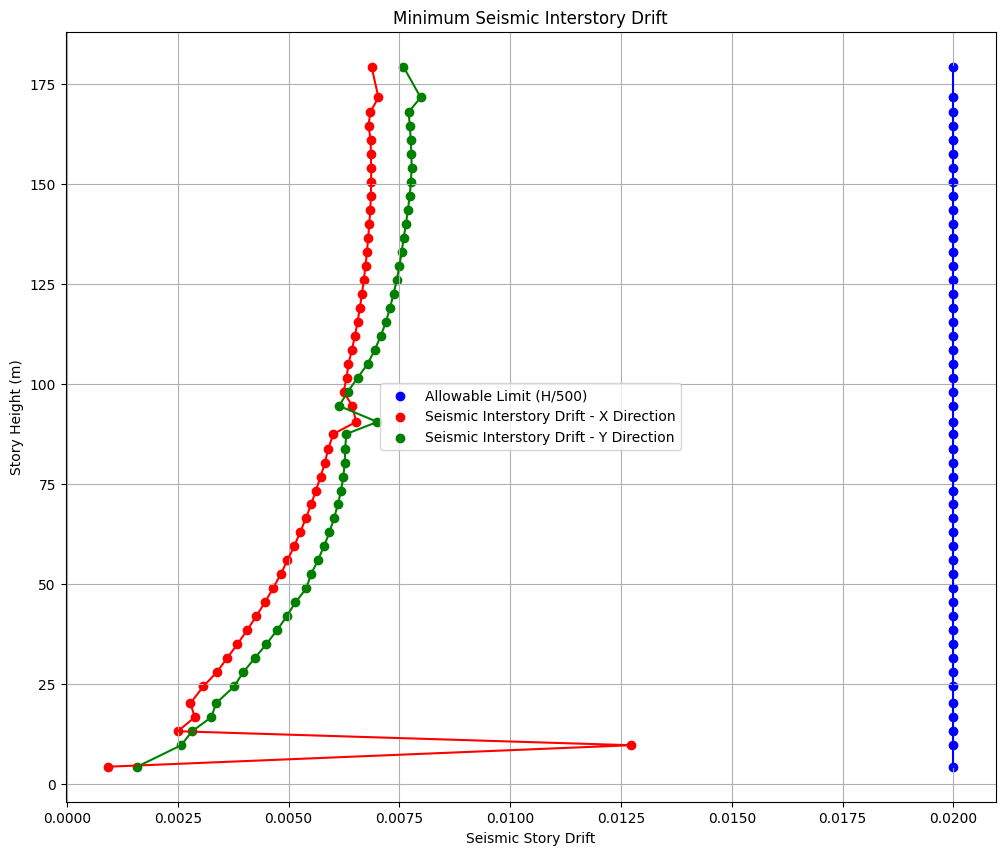

In [465]:
#Set the figure size.
plt.figure(figsize=(12,10))

# Create scatterplot of allowable limit.
plt.scatter(min_seismic_storyDrifts_df['Allowable Limit (H/500)'], min_seismic_storyDrifts_df['Elevation (m)'], label='Allowable Limit (H/500)', color='b')

# Create scatterplot of min seismic interstory drift in x direction.
plt.scatter(min_seismic_storyDrifts_df['Inelastic Seismic Story Drift - X Direction'], min_seismic_storyDrifts_df['Elevation (m)'], label='Seismic Interstory Drift - X Direction', color='r')

# Create scatterplot of min seismic interstory drift in y direction.
plt.scatter(min_seismic_storyDrifts_df['Inelastic Seismic Story Drift - Y Direction'], min_seismic_storyDrifts_df['Elevation (m)'], label='Seismic Interstory Drift - Y Direction', color='g')

#Plot the points with a solid connecting line
plt.plot(min_seismic_storyDrifts_df['Allowable Limit (H/500)'], min_seismic_storyDrifts_df['Elevation (m)'], "b-")
plt.plot(min_seismic_storyDrifts_df['Inelastic Seismic Story Drift - X Direction'], min_seismic_storyDrifts_df['Elevation (m)'], "r-")
plt.plot(min_seismic_storyDrifts_df['Inelastic Seismic Story Drift - Y Direction'], min_seismic_storyDrifts_df['Elevation (m)'], "g-")

# Add label, title, legend, and show the plot.
plt.xlabel('Seismic Story Drift')
plt.ylabel('Story Height (m)')
plt.title('Minimum Seismic Interstory Drift')
plt.legend()
plt.grid(True)
plt.show()